# Sign Detection with VGG19

### Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.applications.vgg16 import VGG16
from keras.models import Model
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg19 import VGG19

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Image Data Augmentation

In [2]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=0.2,
         rotation_range=10, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

data_dir = "ISL-Original/Training"
test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (64, 64),
                                           batch_size=64,
                                       subset='training',
                                           seed=46)
val_ds = test_datagen.flow_from_directory(data_dir,
                                     class_mode = 'categorical',
                                     target_size = (64, 64),
                                     batch_size=64,
                                          subset='validation',
                                     seed=46)

Found 8803 images belonging to 26 classes.
Found 2189 images belonging to 26 classes.


### Declare Metrics 

In [3]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - VGG19

In [4]:
#Initialising vgg16 
classifier_vgg19 = VGG19(input_shape= (64,64,3),include_top=False,weights='imagenet')

#don't train existing weights for vgg16
for layer in classifier_vgg19.layers:
    layer.trainable = False
    
classifier1 = classifier_vgg19.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=26, activation='softmax')(classifier1) #26 units for all gestures

model = Model(inputs = classifier_vgg19.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy',f1, precision,recall])

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [6]:
#fit the model
#it will take some time to train
history = model.fit(train_ds, epochs =10, batch_size = 64,validation_data=val_ds)

Epoch 1/10
138/138 [==============================] - 231s 2s/step - loss: 4.4628 - accuracy: 0.3978 - f1: 0.3811 - precision: 0.5919 - recall: 0.2869 - val_loss: 0.6884 - val_accuracy: 0.8237 - val_f1: 0.8083 - val_precision: 0.9021 - val_recall: 0.7337
Epoch 2/10
138/138 [==============================] - 223s 2s/step - loss: 1.4585 - accuracy: 0.6368 - f1: 0.6243 - precision: 0.7999 - recall: 0.5146 - val_loss: 0.5111 - val_accuracy: 0.8853 - val_f1: 0.8871 - val_precision: 0.9161 - val_recall: 0.8603
Epoch 3/10
138/138 [==============================] - 227s 2s/step - loss: 1.1209 - accuracy: 0.7166 - f1: 0.7163 - precision: 0.8320 - recall: 0.6305 - val_loss: 0.5406 - val_accuracy: 0.8853 - val_f1: 0.8929 - val_precision: 0.9059 - val_recall: 0.8804
Epoch 4/10
138/138 [==============================] - 226s 2s/step - loss: 0.8923 - accuracy: 0.7719 - f1: 0.7737 - precision: 0.8652 - recall: 0.7009 - val_loss: 0.5446 - val_accuracy: 0.8958 - val_f1: 0.8992 - val_precision: 0.9113 -

### Learning Curves - Graph 

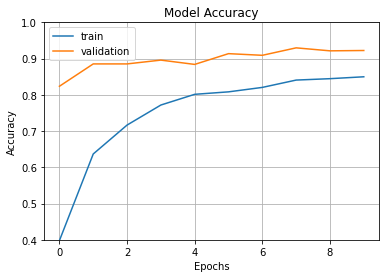

In [7]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

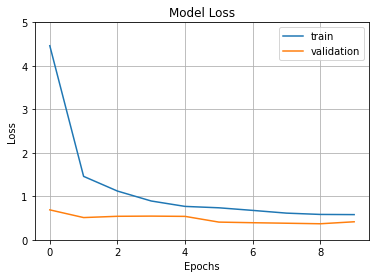

In [8]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=5)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Evaluating the Model 

In [9]:
Y_pred = model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

Text(0.5, 33.0, 'Predicted label')

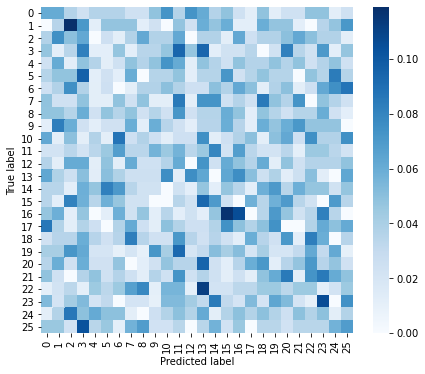

In [10]:
cf_mat = confusion_matrix(val_ds.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [11]:
model.save('vgg19_final_signd.h5')

In [12]:
labels = val_ds.classes
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.06      0.06        82
           1       0.04      0.04      0.04        84
           2       0.04      0.05      0.05        80
           3       0.06      0.08      0.07        85
           4       0.05      0.04      0.04        82
           5       0.03      0.02      0.03        83
           6       0.00      0.00      0.00        80
           7       0.03      0.02      0.02        82
           8       0.03      0.02      0.03        83
           9       0.08      0.06      0.07        84
          10       0.01      0.01      0.01        80
          11       0.05      0.06      0.05        88
          12       0.00      0.00      0.00        82
          13       0.04      0.06      0.05        79
          14       0.01      0.01      0.01        85
          15       0.02      0.02      0.02        86
          16       0.10      0.11      0.10        85
          17       0.04    

['L']

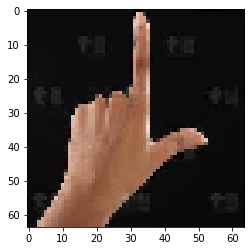

In [20]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_L.jpeg", target_size=(64, 64))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

In [22]:
loss, accuracy, f1_score, precision, recall = model.evaluate(val_ds, verbose=0)

In [23]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')

Test Loss:  41.446 %
Test Accuracy:  92.234 %
Test Precision:  92.806 %
Test Recall:  91.48 %
Test F1 Score:  92.13 %
